# Sistema de recomendacion
## Carga de datos

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../python-ml-course-master/mobielens/ml-100k/u.data',sep="\t",header=None)

In [3]:
df

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [4]:
df.columns = ['UserId','ItemId','Rating','TimeStamp']

In [5]:
df.describe()

,UserId,ItemId,Rating,TimeStamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


## Analisis exploratorio

In [6]:
import matplotlib.pyplot as plt
from matplotlib import style
plt.rcParams['figure.figsize'] = (16,9)
style.use('ggplot')

Text(0.5, 0, 'Califiacion')

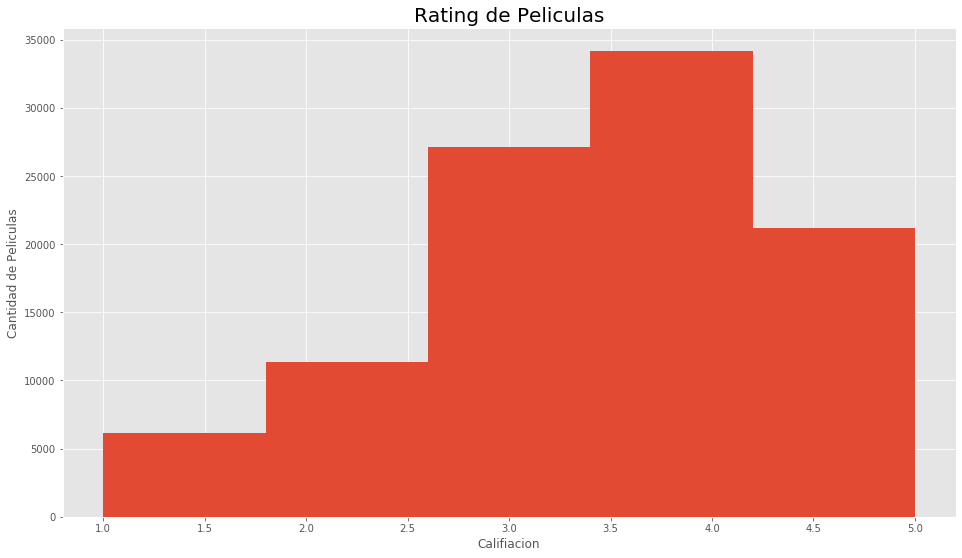

In [7]:
plt.hist(df['Rating'], bins=5)
plt.title('Rating de Peliculas', size=20)
plt.ylabel('Cantidad de Peliculas')
plt.xlabel('Califiacion')

In [8]:
#Cantidad de valoraciones que hay
print(df.groupby('Rating')['UserId'].count())

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserId, dtype: int64


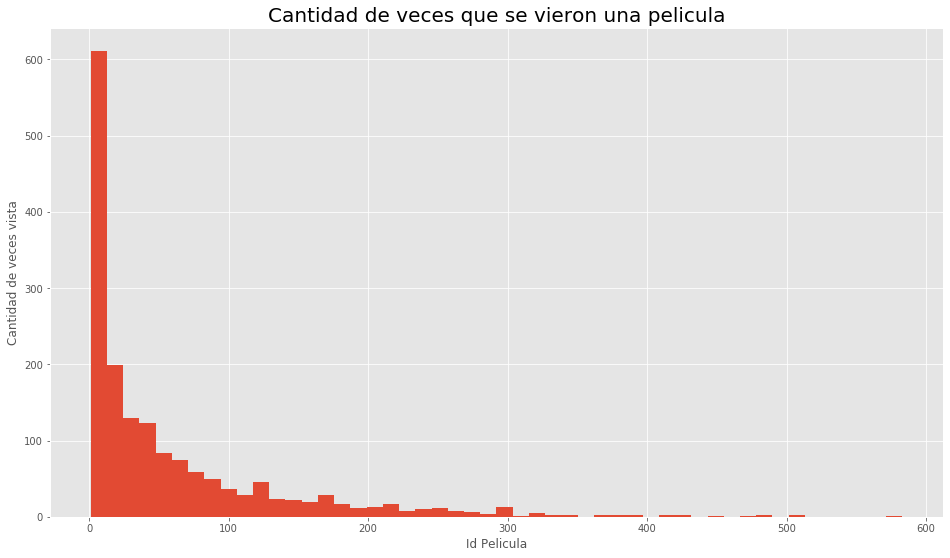

In [9]:
plt.title('Cantidad de veces que se vieron una pelicula', size=20)
plt.xlabel('Id Pelicula')
plt.ylabel('Cantidad de veces vista')
plt.hist(df.groupby(['ItemId'])['ItemId'].count() , bins=50)
plt.show()

## Represenatcion Matricial

In [10]:
import numpy as np

In [11]:
n_users = df['UserId'].unique().shape[0]
n_users

943

In [12]:
n_items = df['ItemId'].unique().shape[0]
n_items

1682

In [13]:
rating = np.zeros((n_users,n_items))
for row in df.itertuples():
    rating[row[1]-1, row[2] - 1 ] = row[3]

In [14]:
rating.shape

(943, 1682)

In [15]:
sparcity = float(len(rating.nonzero()[0]))
sparcity /= (rating.shape[0]*rating.shape[1])
sparcity *=100
print('Porcentaje de matriz que no esta vacia: ',sparcity)

Porcentaje de matriz que no esta vacia:  6.304669364224531


* Esto quiere decir que no concemos cerca de un 95% de margen de datos que no conocemos

## Crear conjunto de entrenamiento y validacion

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
r_train , r_test = train_test_split(rating, test_size=0.2, random_state=42)

In [18]:
r_train.shape

(754, 1682)

In [19]:
r_test.shape

(189, 1682)

In [24]:
print(r_train)

[[0. 0. 0. ... 0. 0. 0.]
 [4. 4. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


* Vamos a tener que buscar usaurios similares y ponderar, es decir predecir en base de otros usuarios que prefiere

## Filtro colaborativo basado en Usuario
* Matriz de similaridad entre los usuarios (utilizaremos la distancia del conseno y K vesinos mas cercanos que conocemos)
* Predecir la valoracion desconocida de un item *i* para un usuario activo *u* basandonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho item
* Recomendaremos los nuevos items segun lo establecido en los pasos anteriores

In [20]:
import sklearn

In [21]:
sin_matriz = 1 - sklearn.metrics.pairwise.cosine_distances(r_train)

In [22]:
print(sin_matriz)
#de esta manera hemos encontrado a los usuarios que se parecen unos con otros

[[1.         0.19449256 0.05784661 ... 0.         0.0837846  0.18419299]
 [0.19449256 1.         0.06141026 ... 0.04786378 0.18984795 0.26737701]
 [0.05784661 0.06141026 1.         ... 0.         0.07432499 0.03489493]
 ...
 [0.         0.04786378 0.         ... 1.         0.04853428 0.05142508]
 [0.0837846  0.18984795 0.07432499 ... 0.04853428 1.         0.1198022 ]
 [0.18419299 0.26737701 0.03489493 ... 0.05142508 0.1198022  1.        ]]


In [25]:
#De esta forma vamos a obtener la prediccion en base de la empoderacion
user_predict = sin_matriz.dot(r_train) / np.array([np.abs(sin_matriz).sum(axis=1)]).T

In [27]:
print(user_predict)

[[2.28942207e+00 5.41241237e-01 3.89719303e-01 ... 0.00000000e+00
  5.21150518e-03 3.05107999e-03]
 [2.55492849e+00 8.19576261e-01 4.32451545e-01 ... 0.00000000e+00
  7.79388060e-03 6.43270506e-03]
 [1.31140901e+00 2.76470029e-01 2.44131270e-01 ... 0.00000000e+00
  2.53013911e-03 1.32746815e-03]
 ...
 [1.71174408e+00 4.04211832e-01 3.14877694e-01 ... 0.00000000e+00
  2.38815289e-03 7.92775426e-03]
 [2.31729269e+00 8.14027190e-01 4.64915916e-01 ... 0.00000000e+00
  8.83791103e-03 8.44575853e-03]
 [2.34558302e+00 6.06246952e-01 3.75682574e-01 ... 0.00000000e+00
  5.56229266e-03 4.67098366e-03]]


In [32]:
# ahora vamos a hacer una funcion para calcular el R^2
def get_mse(preds , actuals):
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return sklearn.metrics.mean_squared_error(preds, actuals)

In [33]:
get_mse(user_predict, r_train)

7.835759457917879

In [34]:
get_mse(user_predict,r_test)

8.93770736175812

## Filtro colaborativo basado en los KNN

In [40]:
from sklearn import neighbors

In [43]:
k = 10
neighbors = neighbors.NearestNeighbors(k , 'cosine')

In [47]:
neighbors.fit(r_train.T)
top_k_distances, top_k_items = neighbors.kneighbors(r_train.T , return_distance=True)

In [48]:
top_k_distances.shape

(1682, 10)

In [49]:
top_k_distances[0]

array([ 0.        , 56.3116329 , 56.9912274 , 58.36951259, 59.40538696,
       59.55669568, 60.51446108, 61.46543744, 61.74139616, 61.98386887])

In [50]:
top_k_items[0]

array([  0, 120, 404, 116, 150, 117, 221, 741, 236,  94])

In [54]:
preds = np.zeros(r_train.T.shape)

#producto escalar a mano:
for i in range(r_train.T.shape[0]):
    if(i%50==0):
        print("iter "+str(i))
    den = 1
    if (np.abs(top_k_distances[i]).sum(axis=0)>0):
        den = np.abs(top_k_distances[i]).sum(axis=0)
    preds[i, :] = top_k_distances[i].dot(r_train.T[top_k_items][i])/np.array([den]).T

iter 0
iter 50
iter 100
iter 150
iter 200
iter 250
iter 300
iter 350
iter 400
iter 450
iter 500
iter 550
iter 600
iter 650
iter 700
iter 750
iter 800
iter 850
iter 900
iter 950
iter 1000
iter 1050
iter 1100
iter 1150
iter 1200
iter 1250
iter 1300
iter 1350
iter 1400
iter 1450
iter 1500
iter 1550
iter 1600
iter 1650
